In [1]:
import os
import tensorflow as tf
import IPython.display as display

# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'


We can check whether there is a gpu avaliable for use

In [2]:
gpu_device_name = tf.test.gpu_device_name()
print(gpu_device_name)

/device:GPU:0


In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import cv2
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
from skimage import io
import PIL.Image
import time
import functools

Now, we are going to set up a function for changing tensor, which is the basic unit for tensorflow, to image. This will allow us to visualize the outputs of neural net. Which is neccessory for this task. 

In [4]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
        return PIL.Image.fromarray(tensor)


Now we write a fuction for loading the image, becuase VGG19 net have a maximum input of 512X512, the maximum dimension should be reduced to no more than 512X512.

In [5]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

Now we can load the content image and the style image into the RAM

In [28]:
content_image = load_img(r'D:\Files\image2.jpg')
style_image = load_img(r'D:\Files\chouxiang.jpg')

# Constracting a neural Network for style transfer from the 

In [29]:
vgg19 = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']


In [30]:
def vgg_layers(layer_names):

    outputs = [vgg19.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg19.input], outputs)
    return model


In [31]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)


We will use gram_matrix for extracting the style, the gram matrix looks like this
$$ G_{ij} = V_{i}^{T}V_{j} $$

In [32]:
def gram_matrix(input_tensor):
    sum = tf.linalg.einsum('bijc, bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    ij = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return sum/ij

In [33]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)

        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}


In [34]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)

opt = tf.optimizers.
Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight = 1e-2
content_weight = 1e4

In [35]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / len(style_layers)

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / len(content_image)
    loss = style_loss + content_loss
    return loss


def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

# Runing the net
now we are going to start with training, with each step reduce the loss 

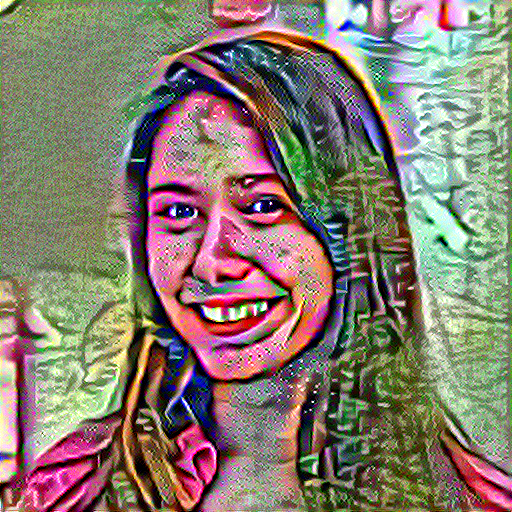

Train step: 200
........................................

KeyboardInterrupt: 

In [36]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))
cv2.imwrite(r'C:\Users\xiayu\style.jpg', image)


In [15]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

NameError: name 'clip_0_1' is not defined

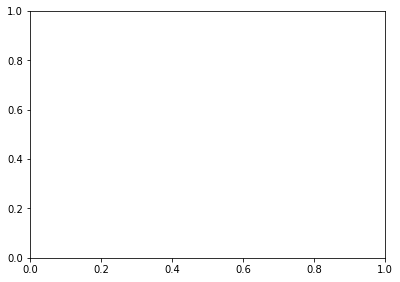

In [17]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
plt.imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
plt.imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
plt.imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
plt.imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")